In [1]:
#  Copyright 2022 Institute of Advanced Research in Artificial Intelligence (IARAI) GmbH.
#  IARAI licenses this file to You under the Apache License, Version 2.0
#  (the "License"); you may not use this file except in compliance with
#  the License. You may obtain a copy of the License at
#  http://www.apache.org/licenses/LICENSE-2.0
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

In [1]:
from IPython.display import display
from IPython.core.display import HTML
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
%matplotlib inline

display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import sys

# Alternatevly, in order to make the module imports work properly set PYTHONPATH=$PWD before launching the notebook server from the repo root folder.
sys.path.insert(0, os.path.abspath("../"))  # noqa:E402

The time module is not an IPython extension.


Autosaving every 60 seconds


In [2]:
import pandas
import geopandas
import numpy as np
import warnings
import osmnx as ox

from collections import namedtuple
from pathlib import Path
from shapely.geometry import LineString

from osmnx.io import utils_graph

from data_pipeline.h5_helpers import load_h5_file, write_data_to_h5
from data_pipeline.dp01_movie_aggregation import generate_15min_aggregates

from data_pipeline.data_helpers import get_latlon_bounds
from data_pipeline.data_helpers import get_intersecting_grid_cells
from data_pipeline.data_helpers import invert_heading
from data_pipeline.data_helpers import get_bin_bounds
from data_pipeline.data_helpers import create_polygon_from_row_col

/usr/local/Caskroom/miniconda/base/envs/t4c/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
BASEDIR = Path('/Users/neun/data/t4c/data_pipeline/debug')
ROAD_GRAPH_DIR = BASEDIR / 'road_graph'

# city = 'london'
# city = 'madrid'
# city = 'melbourne'
# city = 'antwerp'
city = 'moscow'

### Custom Road Graph

In [4]:
graph_file = ROAD_GRAPH_DIR / city / "road_graph.graphml"
g = ox.load_graphml(graph_file)

In [5]:
len(g.edges)

175320

In [6]:
nodes_df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_nodes.parquet')
nodes_df

,node_id,x,y
0,27717690,37.483863,55.890551
1,27778911,37.482659,55.893713
2,27778949,37.480244,55.895172
3,28041755,37.764822,55.827504
4,28043165,37.735747,55.813265
...,...,...,...
10349,10075927894,37.576465,55.705774
10350,10118156468,37.653060,55.574366
10351,10126147374,37.557629,55.540836
10352,10147482059,37.357866,55.605623


In [7]:
edges_df = geopandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_edges.parquet')
edges_df

,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry
0,27717690,5156996365,"[31298748, 1064269061]",48.8,nan,tertiary,False,nan,nan,76.141,"LINESTRING (37.48386 55.89055, 37.48388 55.890..."
1,27717690,3067941815,302546139,48.8,nan,tertiary,True,1,nan,453.861,"LINESTRING (37.48386 55.89055, 37.48382 55.890..."
2,27778911,27778949,31298749,48.8,nan,tertiary,False,nan,nan,228.338,"LINESTRING (37.48266 55.89371, 37.48254 55.893..."
3,27778911,5156996365,31298749,48.8,nan,tertiary,False,nan,nan,284.599,"LINESTRING (37.48266 55.89371, 37.48295 55.893..."
4,27778911,369214425,"[32779500, 993985452, 993985453, 35894759]",48.8,20,tertiary,False,nan,nan,852.475,"LINESTRING (37.48266 55.89371, 37.48251 55.893..."
...,...,...,...,...,...,...,...,...,...,...,...
19860,10075927894,303470676,"[155217739, 1100949940]",48.8,nan,tertiary,True,2,nan,439.498,"LINESTRING (37.57647 55.70577, 37.57598 55.705..."
19861,10118156468,1144215508,"[857650538, 99478972]",52.5,nan,tertiary_link,True,2,nan,60.508,"LINESTRING (37.65306 55.57437, 37.65297 55.574..."
19862,10118156468,1144215508,1105710573,48.8,nan,tertiary,True,nan,nan,38.487,"LINESTRING (37.65306 55.57437, 37.65300 55.574..."
19863,10126147374,1256903520,1106593042,48.8,nan,tertiary,True,2,nan,289.752,"LINESTRING (37.55763 55.54084, 37.55756 55.540..."


In [20]:
# nodes_df, edges_df = utils_graph.graph_to_gdfs(g)

# nodes_df = nodes_df.reset_index()
# nodes_df = nodes_df.rename(columns={'osmid': 'node_id'})
# nodes_df = nodes_df[['node_id', 'x', 'y']]

# edges_df = edges_df.reset_index()

# edges_df = edges_df.rename(columns={'length': 'length_meters'})
# edges_df = edges_df[[
#     'u', 'v', 'speed_kph', 'highway', 'oneway', 'lanes', 'tunnel', 'length_meters']]

In [25]:
# nodes_df

In [26]:
# edges_df

### 15 Minute Aggregates

In [8]:
# This can take a few hours (~1.5 minutes per input file on a normal laptop)
# If you stop and resume make sure that the last existing output file was written completely.
def generate_15min_movies(city):
    generate_15min_aggregates(BASEDIR, city=city, resume=True)
    movie_15min_files = list((BASEDIR / 'movie_15min' / city).glob('*_8ch_15min.h5'))
    print(f'Found {len(movie_15min_files)} 15min movie files for {city}')
    
    
# generate_15min_movies(city)

### Speed Clusters

In [9]:
from ckmeans import ckmeans
import re
import matplotlib.pyplot as plt

def create_clusters(city, num_inputs=20):
    files_15min = sorted(list(
        (BASEDIR / 'movie_15min' / city).glob('*_8ch_15min.h5')))[-40:-40+num_inputs]
    dates = sorted([re.search(r"([0-9]{4}-[0-9]{2}-[0-9]{2})", str(f)).group(1) for f in files_15min])
    data_days = np.empty((len(dates)*96, 495, 436, 8), dtype=float)
    data_days[:] = np.nan
    for i, date in enumerate(dates):
        data = load_h5_file(BASEDIR / 'movie_15min' / city / f"{date}_{city}_8ch_15min.h5")
        print(f'{date} values > 0: {(data > 0).sum()}')
        data_days[i*96:i*96+96] = data
    print(f'Total values > 0: {(data_days > 0).sum()}')
    progress = 0
    speed_clusters = np.zeros(shape=(495,436,4,5,2))
    for s, si in zip([1,3,5,7],[0,1,2,3]):
        for y in range(495):
            for x in range(436):
                progress += 1
                if progress % 10000 == 0:
                    print(f'\rProgress {progress}/{495*436*4}', end='')
                speeds = data_days[:, y, x, s]
                speeds = speeds[~np.isnan(speeds)]
                speeds = speeds.astype('float64')
                speeds = speeds / 255 * 120
                speeds = np.sort(speeds)
                if len(speeds) < 10:
                    continue
                cluts = ckmeans(speeds, 5)
                ccents = [[np.median(c), len(c)] for c in cluts]
                speed_clusters[y][x][si] = ccents
    write_data_to_h5(
        speed_clusters, BASEDIR / 'movie_speed_clusters' / city / "speed_clusters.h5",
        dtype=np.float64)
    return speed_clusters
  

def get_mean_speeds(speed_clusters):
#     print(speed_clusters[273, 230, 3, :, :])
    speeds = np.prod(speed_clusters, axis=4)
#     print(speeds[273, 230, 3, :])
    speeds = np.sum(speeds, axis=3)
#     print(speeds[273, 230, 3])
    vols = np.sum(speed_clusters, axis=3)
#     print(vols[273, 230, 3, :])
    vols = vols[:, :, :, 1]
#     print(vols[273, 230, 3])
#     mean_speeds = np.divide(speeds, vols)
    speeds = np.divide(speeds, vols)
    return speeds, vols
#     print(mean_speeds[273, 230, 3])
#     print()
#     return mean_speeds


def diff_speed_clusters(city, new_speed_clusters):
    old_speed_clusters = load_h5_file(BASEDIR / 'movie_speed_clusters' / city / "speed_clusters_old.h5")
#     old_ms = get_mean_speeds(old_speed_clusters)
#     new_ms = get_mean_speeds(new_speed_clusters)
#     diff_ms = np.absolute(old_ms - new_ms)
#     print(np.nanmean(diff_ms))
#     print(np.nanmax(diff_ms))
#     plt.figure(figsize=(12,6))
#     plt.hist(np.matrix.flatten(diff_ms), bins=50, log=True)
#     plt.figure(figsize=(12,6))
    old_ms, old_mv = get_mean_speeds(old_speed_clusters)
    old_ms = np.matrix.flatten(old_ms)
    old_mv = np.matrix.flatten(old_mv)
    new_ms, new_mv = get_mean_speeds(new_speed_clusters)
    new_ms = np.matrix.flatten(new_ms)
    new_mv = np.matrix.flatten(new_mv)
    plt.figure(figsize=(20,20))
#     plt.scatter(x=old_mv, y=old_ms)
#     plt.scatter(x=new_mv, y=new_ms)
    diff_ms = np.absolute(old_ms - new_ms)
    plt.scatter(x=old_mv, y=diff_ms)
    
    
# diff_speed_clusters('madrid', speed_clusters_madrid)
# diff_speed_clusters('london', speed_clusters_london)

In [16]:
def plot_speed_clusters(speed_clusters):
    sum_data = speed_clusters.sum(axis=(-3, -2 ,-1))
    with np.errstate(divide='ignore'):  # avoids division by zero error
        sum_data = np.where(sum_data > 1, np.log(sum_data), 0)
    plt.figure(figsize=(10,10))
    plt.imshow(sum_data)

# speed_clusters_london = create_clusters('london')
# speed_clusters_london = load_h5_file(BASEDIR / 'movie_speed_clusters' / 'london' / 'speed_clusters.h5')
# plot_speed_clusters(speed_clusters_london)

In [93]:
# diff_speed_clusters('london', speed_clusters_london)

In [49]:
# speed_clusters_madrid = create_clusters('madrid', 20)
# speed_clusters_madrid = load_h5_file(BASEDIR / 'movie_speed_clusters' / 'madrid' / 'speed_clusters.h5')
# plot_speed_clusters(speed_clusters_madrid)

In [50]:
# diff_speed_clusters('madrid', speed_clusters_madrid)

In [52]:
# speed_clusters_melbourne = create_clusters('melbourne')
# speed_clusters_melbourne = load_h5_file(BASEDIR / 'movie_speed_clusters' / 'melbourne' / 'speed_clusters.h5')
# plot_speed_clusters(speed_clusters_melbourne)

In [91]:
# diff_speed_clusters('melbourne', speed_clusters_melbourne)

### Intersecting Cells

In [10]:
def is_edge_geometry_reversed(nodes_dict, u, v, line):
    line = list(line.coords)
    un = nodes_dict[u]
    un = (un['x'], un['y'])
    vn = nodes_dict[v]
    vn = (vn['x'], vn['y'])
    if line[0] == un and line[-1] == vn:
        return False
    else:
        return True

    
def get_intersecting_cells(line, oneway, geometry_reversed, lat_min, lon_min):
    oneway = str(oneway) == 'True'
    # Add an additional point every 30m to make sure we catch all cells
    step_size = 0.0003
    lc = [line.interpolate(d) for d in np.arange(0, line.length+step_size, step_size)]
    line = LineString(lc)
    # Compute the intersecting cells in the corresponding geometry direction.
    intersecting_cells = get_intersecting_grid_cells(line, lon_min, lat_min, reverse=geometry_reversed)
    return intersecting_cells


def generate_intersecting_cells(city):
    lat_min, lat_max, lon_min, lon_max = get_latlon_bounds(city, verbose=True)
    
    nodes_df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_nodes.parquet')
    nodes_dict = {}
    for node_id, x, y in zip(nodes_df['node_id'], nodes_df['x'], nodes_df['y']):
        nodes_dict[node_id] = {'x': x, 'y': y}
    print(f'Loaded {len(nodes_dict)} nodes')
    
    geometries_df = geopandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_geometries.parquet')
    geometries_df = geometries_df[['u', 'v', 'geometry']]
    print(f'Loaded {len(geometries_df)} edge geometries')
    
    edges_df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_edges.parquet')
    edges_df = geometries_df.merge(edges_df, on=['u', 'v'])
    edges_df
    print(f'Loaded {len(edges_df)} edges')
    
    edges_df['geometry_reversed'] = [
        is_edge_geometry_reversed(nodes_dict, u, v, line)
        for u, v, line in zip(edges_df['u'], edges_df['v'], edges_df['geometry'])
    ]
    print(f'{len(edges_df[edges_df["geometry_reversed"]])} have a reversed geometry')
    
    edges_df['intersecting_cells'] = [
        str(get_intersecting_cells(line, oneway, geometry_reversed, lat_min, lon_min))
        for line, oneway, geometry_reversed in zip(
            edges_df['geometry'], edges_df['oneway'], edges_df['geometry_reversed'])
    ]
    print(f'Done generating intersecting cells for {city}')
    return edges_df


def intersecting_cells_equal(icos, icns):
    if icos == 'None' or icns == 'None':
        return False
    if type(icos) == str:
        icos = sorted(eval(icos))
    if type(icns) == str:
        icns = sorted(eval(icns))
    if len(icos) != len(icns):
        return False
    for ico, icn in zip(icos, icns):
        if (ico[0] != icn[0]) or (ico[1] != icn[1]) or (ico[2] != icn[2]):  # x, y and h are int
            return False
        if abs(ico[3] - icn[3]) > 0.1:  # overlap fraction is float
            return False
    return True

def compare_intersecting_cells(old_cells_df, new_cells_df):
    if len(old_cells_df) != len(new_cells_df):
        print(f'New cell mappings length differs: {len(new_cells_df)} != {len(old_cells_df)}')
        return False
    df = old_cells_df.merge(new_cells_df, on=['u', 'v'], how='left')
    for u, v, icos, icns in zip(df['u'], df['v'], df['old_cells'], df['cells']):
        if not intersecting_cells_equal(icos, icns):
            print(f'Found cell mapping difference at {u},{v}\n{icos}\n!=\n{icns}')
            return False
    print('Found no cell mapping differences')
    return True

def check_and_update_cell_mapping(city, edges_df, overwrite=False):
    new_cells_df = edges_df[['u', 'v', 'intersecting_cells']]
    new_cells_df = new_cells_df.rename(columns={'intersecting_cells': 'cells'})
    cell_mapping_fn = ROAD_GRAPH_DIR / city / 'cell_mapping.parquet'
    if cell_mapping_fn.exists():
        old_cells_df = pandas.read_parquet(cell_mapping_fn)
        old_cells_df = old_cells_df.rename(columns={'cells': 'old_cells'})
        print(f'Comparing {len(new_cells_df)} new cell mappings with {len(old_cells_df)} '\
              f'existing ones in {cell_mapping_fn}')
        compare_intersecting_cells(old_cells_df, new_cells_df)
    if overwrite or not cell_mapping_fn.exists():
        print(f'Saving new cell mappings to {cell_mapping_fn}')
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
            new_cells_df.to_parquet(cell_mapping_fn, compression="snappy")


# edges_df = generate_intersecting_cells('london')
# check_and_update_cell_mapping('london', edges_df)

# edges_df = generate_intersecting_cells('madrid')
# check_and_update_cell_mapping('madrid', edges_df)

# edges_df = generate_intersecting_cells('melbourne')
# check_and_update_cell_mapping('melbourne', edges_df)

In [11]:
cells_df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_intersecting_cells.parquet')
cells_df

,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,geometry_reversed,intersecting_cells
0,27717690,5156996365,"[31298748, 1064269061]",48.8,nan,tertiary,False,nan,nan,76.141,b'\x01\x02\x00\x00\x00\x06\x00\x00\x00\xb5\x9f...,False,"[(369, 51, 1, 0.6576988391726114), (369, 50, 0..."
1,27717690,3067941815,302546139,48.8,nan,tertiary,True,1,nan,453.861,b'\x01\x02\x00\x00\x00\n\x00\x00\x00\xb5\x9f18...,False,"[(370, 52, 3, 0.05930228787412883), (371, 54, ..."
2,27778911,27778949,31298749,48.8,nan,tertiary,False,nan,nan,228.338,"b""\x01\x02\x00\x00\x00\x0c\x00\x00\x00F\xcdW\x...",False,"[(372, 47, 1, 0.2611571262989164), (370, 47, 1..."
3,27778911,5156996365,31298749,48.8,nan,tertiary,False,nan,nan,284.599,b'\x01\x02\x00\x00\x00\t\x00\x00\x00F\xcdW\xc9...,False,"[(369, 48, 2, 0.043229225983358224), (370, 48,..."
4,27778911,369214425,"[32779500, 993985452, 993985453, 35894759]",48.8,20,tertiary,False,nan,nan,852.475,b'\x01\x02\x00\x00\x00(\x00\x00\x00F\xcdW\xc9\...,False,"[(377, 49, 3, 0.07245466777735791), (380, 49, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19860,10075927894,303470676,"[155217739, 1100949940]",48.8,nan,tertiary,True,2,nan,439.498,b'\x01\x02\x00\x00\x00\r\x00\x00\x00\xda\xe2\x...,False,"[(281, 238, 3, 0.15392007433780164), (279, 237..."
19861,10118156468,1144215508,"[857650538, 99478972]",52.5,nan,tertiary_link,True,2,nan,60.508,b'\x01\x02\x00\x00\x00\x08\x00\x00\x00\x06(\xb...,False,"[(200, 367, 3, 0.9084128013308977), (199, 367,..."
19862,10118156468,1144215508,1105710573,48.8,nan,tertiary,True,nan,nan,38.487,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\x06(\xb...,False,"[(200, 367, 3, 0.1931084470650784), (200, 368,..."
19863,10126147374,1256903520,1106593042,48.8,nan,tertiary,True,2,nan,289.752,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\xcf\xe7...,False,"[(297, 400, 1, 0.23828311527471913), (296, 400..."


Extracted 45118 cells


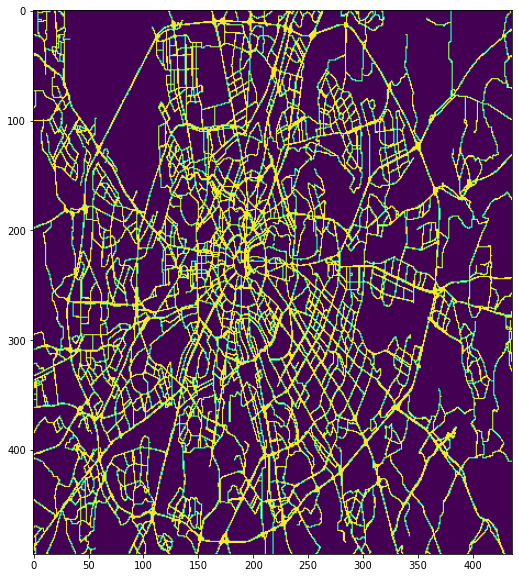

In [13]:
import matplotlib.pyplot as plt

def plot_intersecting_cells(cells_df):
    def extract_cells(cells_df):
        for c in cells_df['intersecting_cells']:
            c = eval(c)
            for x, y, _, _ in c:
                yield x, y

    cells_only = list(set(extract_cells(cells_df)))
    print(f'Extracted {len(cells_only)} cells')
    ar = np.array(cells_only)             # Convert list to numpy array
    res = np.zeros((495,436), dtype=int)  # Create, the result array; initialize with 0
    res[ar[:,0], ar[:,1]] = 1             # Use ar as a source of indices, to assign 1
    plt.figure(figsize=(10,10))
    plt.imshow(res)


cells_df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_intersecting_cells.parquet')
plot_intersecting_cells(cells_df)

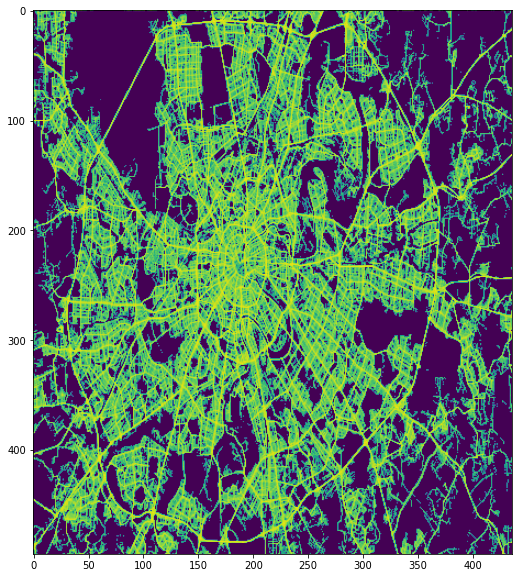

In [17]:
speed_clusters = load_h5_file(BASEDIR / 'movie_speed_clusters' / city / 'speed_clusters.h5')
plot_speed_clusters(speed_clusters)

(96, 495, 436, 8)
0.0


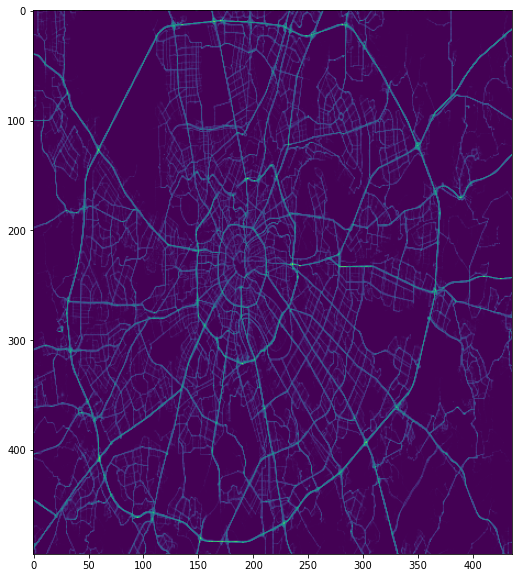

In [18]:
def plot_movie(movie15):
    print(movie15.shape)
    movie15 = np.nan_to_num(movie15)
    sum_data = movie15.sum(axis=(0, -1))
    print(sum_data.min())
    plt.figure(figsize=(10,10))
    plt.imshow(sum_data)

movie15_files = list((BASEDIR / 'movie_15min' / city).glob('*.h5'))
movie15 = load_h5_file(movie15_files[0])
plot_movie(movie15)

### Free Flow Speeds

In [19]:
# ATTENTION: also exists in prepare_training_data_cc.py, make sure to keep in sync
def free_flow_speed_limit(free_flow_kph, speed_limit_kph):
    if not free_flow_kph or np.isnan(free_flow_kph) or free_flow_kph < 20:
        free_flow_kph = 20
    if speed_limit_kph >= 5 and free_flow_kph > speed_limit_kph:
        free_flow_kph = speed_limit_kph
    # Reduce free flow to max 60% but not below, e.g. 32->20, 50->30, 80->48, 110->66
    free_flow_kph = max(free_flow_kph, speed_limit_kph*0.6)
    return free_flow_kph


def extract_merged_speed_clusters(speed_clusters, intersecting_cells):
    merged_speed_clusters = []
    for  i, (r,c,h, _) in enumerate(intersecting_cells):
        r = int(r)
        c = int(c)
        h = int(h)
        merged_speed_clusters.extend([list(x) for x in speed_clusters[r,c,h,:]])
    merged_speed_clusters = sorted(merged_speed_clusters)
    return np.array(merged_speed_clusters)

def get_free_flow(heading_speeds, speed_limit=-1, volume_threshold=0.2):
    lhs = len(heading_speeds)-1
    if heading_speeds[lhs, 0] < speed_limit:
        return heading_speeds[lhs, 0]
    num_speeds = sum(heading_speeds[:,1])
    if num_speeds == 0:
        return np.nan
    vol_num_speeds = 0
    for i in range(lhs,-1,-1):
        vol_num_speeds += heading_speeds[i, 1]
        if vol_num_speeds / num_speeds > volume_threshold:
            free_flow = heading_speeds[i, 0]
            return free_flow
    return np.nan

def extract_free_flow_kph(
    speed_clusters, intersecting_cells, oneway, speed_limit_kph=-1, debug=False):
    intersecting_cells = eval(intersecting_cells)
    if len(intersecting_cells) == 0:
        return -1
    # For two-way also add the opposite headings.
    all_intersecting_cells = intersecting_cells[:]
    if not oneway or oneway == 'False':
        for ic in intersecting_cells:
            all_intersecting_cells.append((ic[0],ic[1],invert_heading(int(ic[2])),ic[3]))
            
#     all_intersecting_cells = all_intersecting_cells[4:]
    
    # Aggregate the speed clusters.
    merged_speed_clusters = extract_merged_speed_clusters(speed_clusters, all_intersecting_cells)
    free_flow = get_free_flow(merged_speed_clusters, speed_limit_kph)
    if debug:
        print(speed_limit_kph)
        print(oneway)
        print(type(oneway))
        print(all_intersecting_cells)
        print(len(all_intersecting_cells))
        print(merged_speed_clusters)
        print(free_flow)
#     if False: #False for london, True for melbourne?
#         free_flow = free_flow_speed_limit(free_flow, speed_limit_kph)
    return free_flow


def generate_free_flow_edges(speed_clusters, df, city, use_speed_limit=True, debug=False):   
    if use_speed_limit:
        # speed_limit_kph = read_speed_limit_kph(f, parse_maxspeed=(self.city=='madrid'))
        df['free_flow_kph'] = [
            extract_free_flow_kph(speed_clusters, ic, oneway, speed_limit_kph, debug)
            for ic, oneway, speed_limit_kph in zip(
                df['intersecting_cells'], df['oneway'], df['speed_kph'])
        ]
    else:
        df['free_flow_kph'] = [
            extract_free_flow_kph(speed_clusters, ic, oneway, debug=debug)
            for ic, oneway in zip(df['intersecting_cells'], df['oneway'])
        ]
    print(f'{len(df[df["free_flow_kph"].isna()])}/{len(df)} edges in {city} have NaN freeflow')
    return df
    

def generate_free_flow(city, use_speed_limit=False):
    speed_clusters = load_h5_file(BASEDIR / 'movie_speed_clusters' / city / 'speed_clusters.h5')
    print(f'Loaded speed clusters {speed_clusters.shape} for {city}')
    df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_edges.parquet')
    cell_df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'cell_mapping.parquet')
    cell_df = cell_df.rename(columns={'cells': 'intersecting_cells'})
    df = df.merge(cell_df, on=['u', 'v'])
#     df = pandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_cells.parquet')
    print(f'Loaded {len(df)} edges with intersecting cells for {city}')
    df = generate_free_flow_edges(speed_clusters, df, city, use_speed_limit=use_speed_limit)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
        rg_fn = ROAD_GRAPH_DIR / city / 'road_graph_freeflow.parquet'
        df.to_parquet(rg_fn, compression="snappy")
        print(f'Saved freeflow to {rg_fn}')
    return df


# edges_df = generate_free_flow('london', use_speed_limit=True)
# edges_df = generate_free_flow('madrid')
# edges_df = generate_free_flow('melbourne')

# Loaded speed clusters (495, 436, 4, 5, 2) for london
# Loaded 132414 edges with intersecting cells for london
# 0/132414 edges in london have NaN freeflow
# Saved freeflow to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/road_graph/london/road_graph_freeflow.parquet
# Loaded speed clusters (495, 436, 4, 5, 2) for madrid
# Loaded 121902 edges with intersecting cells for madrid
# 126/121902 edges in madrid have NaN freeflow
# Saved freeflow to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/road_graph/madrid/road_graph_freeflow.parquet
# Loaded speed clusters (495, 436, 4, 5, 2) for melbourne
# Loaded 94871 edges with intersecting cells for melbourne
# 1086/94871 edges in melbourne have NaN freeflow
# Saved freeflow to /Users/neun/data/t4c/2022_comp_data/prepare_speed_classes/road_graph/melbourne/road_graph_freeflow.parquet

# 579260	579352	
# 579260	814333	
# tu, tv = (9160844995367865137, 623017680)
# generate_free_flow_edges(
#     edges_df[(edges_df['u'] == tu) & (edges_df['v'] == tv)], city, use_speed_limit=False, debug=True)

### Speed Classes

In [23]:
# edges_df = geopandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_freeflow.parquet')
# print(f'Loaded {len(edges_df)} edges with free flow speed')

In [24]:
# edges_df.head()

In [20]:
SegmentSpeedStats = namedtuple("SegmentSpeedStats", [
    "volumes", "speeds", "median_speeds", "median_speeds_kph", "mean_speeds", "mean_speeds_kph"])


def extract_segment_speeds(data_aggregated_day, intersecting_cells):
    vols = np.zeros(shape=(data_aggregated_day.shape[0],))
    speeds = np.zeros(shape=(len(intersecting_cells),data_aggregated_day.shape[0]))
    # ((row,column,heading,heading_volume,overlap))
    # heading_volume is the heatmap volume
    for  i, (r,c,h, _) in enumerate(intersecting_cells):
        r = int(r)
        c = int(c)
        h = int(h)
        vols += data_aggregated_day[:,r,c,2*h]
        # TODO: add speed weighting by overlap here?!
        speeds[i]= data_aggregated_day[:,r,c,2*h+1]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        median_speeds = np.nanmedian(speeds, axis=0)
        mean_speeds = np.nanmean(speeds, axis=0)
    median_speeds_kph = median_speeds/255*120
    mean_speeds_kph = mean_speeds/255*120
    return SegmentSpeedStats(
        vols, speeds, median_speeds, median_speeds_kph, mean_speeds, mean_speeds_kph)

def extract_sc_features(edges_df, date, data_aggregated_day, slot_offset=0):
    road_graph_size = len(edges_df)
    result_data = []
    slots = data_aggregated_day.shape[0]
    for i, u, v, intersecting_cells, free_flow_kph, speed_limit_kph in zip(
        range(road_graph_size), edges_df['u'], edges_df['v'],
        edges_df['intersecting_cells'], edges_df['free_flow_kph'], edges_df['speed_kph']
    ):
        speed_stats = extract_segment_speeds(data_aggregated_day, intersecting_cells)
        assert speed_stats.volumes.shape == (slots,), speed_stats.volumes.shape
        assert speed_stats.speeds.shape == (len(speed_stats.speeds), slots), speed_stats.speeds.shape
        for t in range(slots):
            median_speed = speed_stats.median_speeds[t]
            if np.isnan(median_speed) or median_speed == 0 or median_speed == 255:
                continue
            median_speed_kph = speed_stats.median_speeds_kph[t]
            if np.isnan(median_speed_kph) or median_speed_kph <= 0 or median_speed_kph >= 120:
                continue
            probe_volume = speed_stats.volumes[t]
            if np.isnan(probe_volume) or probe_volume <= 0:
                continue

            normalized_speed = free_flow_speed_limit(free_flow_kph, speed_limit_kph)
            congestion_factor = median_speed_kph / normalized_speed
            
            if u == 579260 and v == 814333:
                print((t, probe_volume, median_speed_kph, normalized_speed, congestion_factor, free_flow_kph, speed_limit_kph))
            
            # Low congestion factor (aka traffic jam) needs more volume to be trusted.
            # Otherwise could also just be a stopping car.
            if probe_volume < 5 and congestion_factor < 0.4:
                continue
            if probe_volume < 3 and congestion_factor < 0.8:
                continue
            if probe_volume < 1:
                continue

            volume_class = int(np.floor((np.clip(probe_volume, 1, 5) + 1) / 2) * 2 - 1)
            tt = slot_offset+t
            d = {
                'u': u, 'v': v, 'day': date, 't': tt,
                'volume_class': volume_class, 'median_speed_kph': median_speed_kph,
                'free_flow_kph': free_flow_kph
            }
            result_data.append(d)
        if (i+1) % 5000 == 0 or i >= road_graph_size-1:
            print(f'\rProgress {i+1}/{road_graph_size}', end='')
    return result_data

def generate_speed_class_edges(edges_df, date, city):
    fn = BASEDIR / 'movie_15min' / city / f'{date}_{city}_8ch_15min.h5'
    print(f'Processing {fn} ...')
    data_aggregated_day = load_h5_file(fn)
    data = extract_sc_features(edges_df, date, data_aggregated_day)
    return pandas.DataFrame.from_dict(data)


def generate_speed_classes(date, city):
    edges_df = geopandas.read_parquet(ROAD_GRAPH_DIR / city / 'road_graph_freeflow.parquet')
    print(f'Loaded {len(edges_df)} edges with free flow speed')
    return generate_speed_class_edges(edges_df, date, city)

# sc_df = generate_speed_classes('2019-07-01', 'london')
# sc_df = generate_speed_classes(edges_df[(edges_df['u'] == 539344006) & (edges_df['v'] == 8014860932)], '2019-07-01', 'london')
# sc_df.to_parquet(BASEDIR / 'speed_classes' / city / f'speed_classes_{date}.parquet', compression="snappy")
# sc_df = generate_speed_classes('2020-06-01', 'melbourne')
# sc_df

In [21]:
# dates = sorted([str(fp).split('/')[-1][:10] for fp in (BASEDIR / 'movie_15min' / city).glob('*8ch_15min.h5')])
# dates

In [22]:
# for date in dates:
#     sc_df = generate_speed_classes(edges_df, date)
#     sc_fn = BASEDIR / 'speed_classes' / city / f'speed_classes_{date}.parquet'
#     sc_fn.parent.mkdir(parents=True, exist_ok=True)
#     sc_df.to_parquet(sc_fn, compression="snappy")
#     print(f'Saved {len(sc_df)} speed_classes to {sc_fn}')

### Check the final output

In [25]:
sc_files = list((BASEDIR / 'speed_classes' / city).glob('*.parquet'))
sc_df = pandas.read_parquet(sc_files[0])
sc_df

,u,v,gkey,day,t,volume_class,median_speed_kph,free_flow_kph
0,27717690,5156996365,-1530886382229550714,2019-01-02,0,3,27.294118,27.176471
1,27717690,5156996365,-1530886382229550714,2019-01-02,2,5,23.294118,27.176471
2,27717690,5156996365,-1530886382229550714,2019-01-02,3,5,27.764706,27.176471
3,27717690,5156996365,-1530886382229550714,2019-01-02,4,5,23.058824,27.176471
4,27717690,5156996365,-1530886382229550714,2019-01-02,5,3,21.882353,27.176471
...,...,...,...,...,...,...,...,...
1654081,10147518595,2799616082,4361841192032423529,2019-01-02,90,5,53.647059,43.764706
1654082,10147518595,2799616082,4361841192032423529,2019-01-02,91,5,40.941176,43.764706
1654083,10147518595,2799616082,4361841192032423529,2019-01-02,92,5,38.470588,43.764706
1654084,10147518595,2799616082,4361841192032423529,2019-01-02,93,5,36.627451,43.764706


In [26]:
scd_df = sc_df.groupby(by=['u', 'v', 'gkey', 'day']).count()
scd_df = scd_df[['t']]
scd_df = scd_df.rename(columns={'t': 'count'})
scd_df = scd_df.reset_index()
scd_df = scd_df.merge(edges_df, on=['u', 'v'])
scd_df

,u,v,gkey,day,count,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry
0,27717690,3067941815,2192543298130394397,2019-01-02,96,302546139,48.8,nan,tertiary,True,1,nan,453.861,"LINESTRING (37.48386 55.89055, 37.48382 55.890..."
1,27717690,5156996365,-1530886382229550714,2019-01-02,91,"[31298748, 1064269061]",48.8,nan,tertiary,False,nan,nan,76.141,"LINESTRING (37.48386 55.89055, 37.48388 55.890..."
2,27778911,27778949,2095397586648054818,2019-01-02,89,31298749,48.8,nan,tertiary,False,nan,nan,228.338,"LINESTRING (37.48266 55.89371, 37.48254 55.893..."
3,27778911,369214425,1808768699028691096,2019-01-02,76,"[32779500, 993985452, 993985453, 35894759]",48.8,20,tertiary,False,nan,nan,852.475,"LINESTRING (37.48266 55.89371, 37.48251 55.893..."
4,27778911,5156996365,-4230849281341763666,2019-01-02,87,31298749,48.8,nan,tertiary,False,nan,nan,284.599,"LINESTRING (37.48266 55.89371, 37.48295 55.893..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19836,10118156468,1144215508,97159719655450176,2019-01-02,93,1105710573,48.8,nan,tertiary,True,nan,nan,38.487,"LINESTRING (37.65306 55.57437, 37.65300 55.574..."
19837,10118156468,1144215508,8272060521078619979,2019-01-02,93,"[857650538, 99478972]",52.5,nan,tertiary_link,True,2,nan,60.508,"LINESTRING (37.65306 55.57437, 37.65297 55.574..."
19838,10118156468,1144215508,8272060521078619979,2019-01-02,93,1105710573,48.8,nan,tertiary,True,nan,nan,38.487,"LINESTRING (37.65306 55.57437, 37.65300 55.574..."
19839,10126147374,1256903520,3942030241220572288,2019-01-02,56,1106593042,48.8,nan,tertiary,True,2,nan,289.752,"LINESTRING (37.55763 55.54084, 37.55756 55.540..."


In [35]:
scd_gdf = geopandas.GeoDataFrame(scd_df, geometry='geometry')
# scd_gdf
scd_gdf.to_file(BASEDIR / 'speed_classes' / city / 'density.gpkg', driver="GPKG", layer="sc_density")

In [36]:
sc9am_df = sc_df[sc_df['t'] == 36]
sc9am_df = sc9am_df.merge(edges_df, on=['u', 'v'])
sc9am_gdf = geopandas.GeoDataFrame(sc9am_df, geometry='geometry')
sc9am_gdf.to_file(BASEDIR / 'speed_classes' / city / 'density.gpkg', driver="GPKG", layer="sc_9am")
sc9am_gdf

,u,v,gkey,day,t,volume_class,median_speed_kph,free_flow_kph,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry
0,27717690,5156996365,-1530886382229550714,2019-01-02,36,5,12.392157,27.176471,"[31298748, 1064269061]",48.8,nan,tertiary,False,nan,nan,76.141,"LINESTRING (37.48386 55.89055, 37.48388 55.890..."
1,27717690,3067941815,2192543298130394397,2019-01-02,36,5,52.627451,63.058824,302546139,48.8,nan,tertiary,True,1,nan,453.861,"LINESTRING (37.48386 55.89055, 37.48382 55.890..."
2,27778911,27778949,2095397586648054818,2019-01-02,36,5,17.882353,27.764706,31298749,48.8,nan,tertiary,False,nan,nan,228.338,"LINESTRING (37.48266 55.89371, 37.48254 55.893..."
3,27778911,5156996365,-4230849281341763666,2019-01-02,36,5,13.647059,25.882353,31298749,48.8,nan,tertiary,False,nan,nan,284.599,"LINESTRING (37.48266 55.89371, 37.48295 55.893..."
4,27778911,369214425,1808768699028691096,2019-01-02,36,5,8.470588,21.647059,"[32779500, 993985452, 993985453, 35894759]",48.8,20,tertiary,False,nan,nan,852.475,"LINESTRING (37.48266 55.89371, 37.48251 55.893..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17111,10118156468,1144215508,8272060521078619979,2019-01-02,36,5,23.058824,23.215686,"[857650538, 99478972]",52.5,nan,tertiary_link,True,2,nan,60.508,"LINESTRING (37.65306 55.57437, 37.65297 55.574..."
17112,10118156468,1144215508,8272060521078619979,2019-01-02,36,5,23.058824,23.215686,1105710573,48.8,nan,tertiary,True,nan,nan,38.487,"LINESTRING (37.65306 55.57437, 37.65300 55.574..."
17113,10118156468,1144215508,97159719655450176,2019-01-02,36,5,23.058824,31.333333,"[857650538, 99478972]",52.5,nan,tertiary_link,True,2,nan,60.508,"LINESTRING (37.65306 55.57437, 37.65297 55.574..."
17114,10118156468,1144215508,97159719655450176,2019-01-02,36,5,23.058824,31.333333,1105710573,48.8,nan,tertiary,True,nan,nan,38.487,"LINESTRING (37.65306 55.57437, 37.65300 55.574..."


In [29]:
# mv9am = load_h5_file(BASEDIR / 'movie_15min' / city / '2019-01-09_ANTWERP_8ch_15min.h5')
mv9am = load_h5_file(BASEDIR / 'movie_15min' / city / '2019-01-02_MOSCOW_8ch_15min.h5')
mv9am.shape

(96, 495, 436, 8)

In [30]:
# x = 221
# y = 189
# NW=1
# SE=2
mv9am[36, 183, 226]

array([ 0., nan,  0., nan,  0., nan,  0., nan])

In [31]:
from geojson import Feature
from fiona.crs import from_epsg

def create_heatmap(city):
    movie_files = list((BASEDIR / 'movie_15min' / city).glob('*.h5'))
    print(f"Found {len(movie_files)} files, e.g. {movie_files[:2]}")
    tfd = load_h5_file(movie_files[0])[:,:,:,[0,2,4,6]]
    print(tfd.shape)
    heatmap = np.sum(tfd, axis=0)
    print(heatmap.shape)
    days = 1
    for tf in movie_files:
        tfd = load_h5_file(tf)[:,:,:,[0,2,4,6]]
        tfd = np.sum(tfd, axis=0)
        heatmap += tfd
        days += 1
    heatmap = heatmap / days
    print(heatmap.shape)
    print(heatmap.dtype)
    return heatmap


def get_bin_polygons(city, heatmap):
    min_lat_bin, max_lat_bin, min_lon_bin, max_lon_bin = get_bin_bounds(city)
    (min_lat, max_lat, min_lon, max_lon), rotate = get_latlon_bounds(city)
    print(heatmap.shape)
    y_size, x_size, _ = heatmap.shape 
    for y in range(y_size):
        lat_bin = min_lat_bin + ((y_size - y - 1) * 100)
        for x in range(x_size):
            lon_bin = min_lon_bin + (x * 100)
            heat = list(heatmap[y, x, :])
            heat_sum = sum(heat)
            if heat_sum < 1:
                continue
            bin_polygon = create_polygon_from_row_col(y, x, min_lon, min_lat, rotate)
            yield Feature(
                geometry=bin_polygon,
                properties={"lat_bin":lat_bin, "lon_bin":lon_bin, "x":x, "y":y, "vol_sum": heat_sum,
                            "vol0_ne":heat[0], "vol1_nw":heat[1], "vol2_se":heat[2], "vol3_sw":heat[3]}
            )
            

def create_heatmap_gpkg(city, heatmap):
    heatmap = heatmap.astype('float64')
    heatmap_features = list(get_bin_polygons(city, heatmap))
    print(heatmap_features[2])
    print(len(heatmap_features))

    gdf = geopandas.GeoDataFrame.from_features(heatmap_features)
    gdf.to_file(BASEDIR / 'movie_15min' / city / "probe_heatmap.gpkg", layer='heatmap',
                driver='GPKG', crs=from_epsg(4326), mode="w", overwrite=True)

In [32]:
heatmap = create_heatmap(city)

Found 8 files, e.g. [PosixPath('/Users/neun/data/t4c/data_pipeline/debug/movie_15min/moscow/2019-01-08_MOSCOW_8ch_15min.h5'), PosixPath('/Users/neun/data/t4c/data_pipeline/debug/movie_15min/moscow/2019-01-09_MOSCOW_8ch_15min.h5')]
(96, 495, 436, 4)
(495, 436, 4)
(495, 436, 4)
float64


In [33]:
create_heatmap_gpkg(city, heatmap)

(495, 436, 4)
{"geometry": {"coordinates": [[[37.852, 55.94], [37.852, 55.939], [37.853, 55.939], [37.853, 55.94], [37.852, 55.94]]], "type": "Polygon"}, "properties": {"lat_bin": 5600000, "lon_bin": 3736000, "vol0_ne": 8.777777777777779, "vol1_nw": 23.333333333333332, "vol2_se": 17.77777777777778, "vol3_sw": 17.77777777777778, "vol_sum": 67.66666666666667, "x": 2, "y": 0}, "type": "Feature"}
132533


/usr/local/Caskroom/miniconda/base/envs/t4c/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
